Source: https://blog.dominodatalab.com/fitting-gaussian-process-models-python/


In [1]:
import numpy as np
import copy
 
# Using squared exponential covariance K    
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)
    # param[0] is vertical scaling factor
    # param[1] is (1 / horizontal scaling factor)

# Conditional function (linear algebra B14)
def conditional(x_new, x, y, params):
    # params are scaling factors
    B = exponential_cov(x_new, x, params) # SigmaXY
    C = exponential_cov(x, x, params) # SigmaYY
    A = exponential_cov(x_new, x_new, params) # SigmaXX
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())


1.0


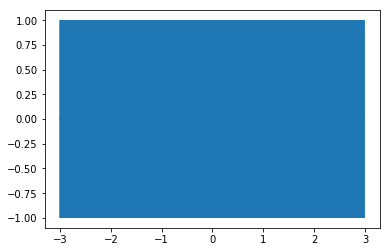

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

θ = [1, 10] # params - scaling factors
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
print(σ_0)

Now, we define the underlying function y which we will try to predict. We then take the first sample at an arbitrary point x = 1.0

In [4]:
x = [1.] # Make x float type

def f1(x):
    output = [np.sin(entry) for entry in x]
    return output

y = f1(x)
y

[0.8414709848078965]

Find out what predict() does?

In [6]:
# Update covariance matrix
σ_1 = exponential_cov(x, x, θ)

# predict(i, x, exponential_cov, θ, σ_2, y)
def predict(x, data_x, kernel, params, sigma, data_y):
    """
    x -> x_new, which are all points to be predicted on the plotted graph
    data -> all previous data points
    """
    k = [kernel(x, y, params) for y in data_x] # for each x_new, calculate covariance with all previous data points
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(data_y)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-5, 5, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]


In [7]:
print(σ_1)

[[1.]]


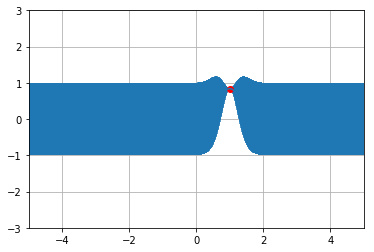

In [8]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

# Change settings of plot
plt.axis([-5, 5, -3, 3])
plt.grid(True)

In [7]:
# Add new datapoint x = 0.7 and recalculate 
x2 = [-0.7]
m2, s2 = conditional(x2, x, y, θ)

# y2 = np.random.normal(m2, s2)

y2 = f1(x2)

x.append(x2[0])

y.append(y2[0])

σ_2 = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]


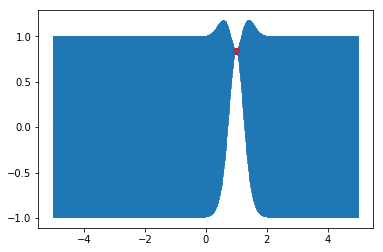

In [9]:
y_pred, sigmas = np.transpose(predictions)

plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)

plt.plot(x, y, "ro")


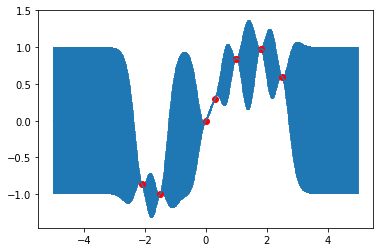

In [10]:
x_more = [-2.1, -1.5, 0.0, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
# y_more = np.random.multivariate_normal(mu, s)
y_more = f1(x_more)

x += x_more
y += y_more
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")


# Implementing Acquisitions Functions

Probability of Improvement (PI)

Expected Improvement (EI)

In [11]:
def f2(x):
    output = [np.cos(entry) - 0.1*entry**2 - 0.6*entry for entry in x]
    return output

In [35]:
# Restarting x points
x = [-3.1, -1.5, 3.5]
y = f2(x)

σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)

[-1.4964964964964964]
[-3.1, -1.5, 3.5, -1.4964964964964964]
New point is same


Text(0.5,1,'Sigmas')

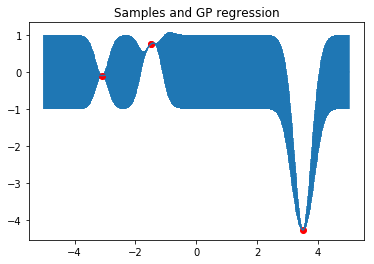

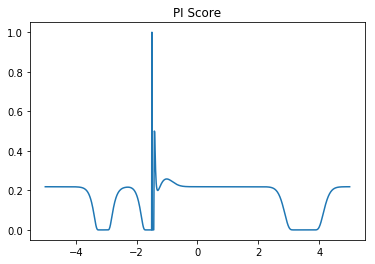

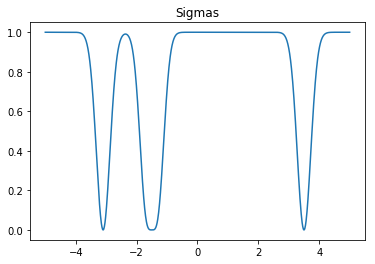

In [37]:
from scipy.stats import norm

current_best_y = max(y_pred)
PI = norm.cdf((y_pred - current_best_y) / sigmas)
max_index = np.argmax(PI)
new_x = [x_pred[max_index]]
new_y = f2(new_x)

print(new_x)
print(x)

if new_x in x:
    print("New point is same")
else: 
    x += new_x
    y += new_y

σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)

plt.figure(1)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.title("Samples and GP regression")
plt.plot(x, y, "ro")

plt.figure(2)
plt.title("PI Score")
plt.plot(x_pred, PI)

plt.figure(3)
plt.plot(x_pred, sigmas)
plt.title("Sigmas")

In [42]:
max_index = np.argmax(PI)
new_x = [x_pred[max_index]]
new_y = f2(new_x)


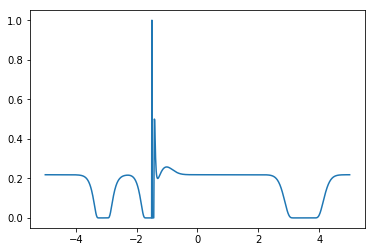

In [15]:
def PI(y_pred, current_best_y, sigmas):
    # Predicted improvement acquisition function
    PI = norm.cdf((y_pred - current_best_y) / sigmas)
    max_index = np.argmax(PI)
    return max_index

def EI(y_pred, current_best_y, sigmas):
    # Expected improvement acquisition function
    numerator = (y_pred - current_best_y) * norm.cdf((y_pred - current_best_y) / sigmas) 
    denominator = sigmas * norm.pdf((y_pred - current_best_y) / sigmas)
    EI = numerator/denominator
    chosen_index = np.argmax(EI)
    return chosen_index

def UCB(x_pred, current_best_y, sigmas):
    return 0

def BO(x, test_func, budget = 5, acq_func = PI, kernel = exponential_cov, kernel_pars = θ):
    x_pred = np.linspace(-3, 3, 1000)
    improvement = True
    
    # Repeat until run out of budget or no further improvement possible
    while budget > 0 and improvement == True:
        budget -= 1
        
        # Finds new_x with largest PI. If starting from no samples, x_new defaults as 0.0
        if len(x) == 0:
            new_x = [0.0] # default value
            new_y = test_func(new_x)

        else:
            y = test_func(x)
            σ = exponential_cov(x, x, θ)
            predictions = [predict(i, x, exponential_cov, θ, σ, y) for i in x_pred]
            y_pred, sigmas = np.transpose(predictions)
            current_best_y = max(y)
            chosen_index = acq_func(y_pred, current_best_y, sigmas)
            new_x = [x_pred[chosen_index]]
            print(chosen_index)
            print("New sample point: %f" % new_x[0])
            PI = norm.cdf((x_pred - current_best_y) / sigmas)
            plt.figure()
            plt.plot(x_pred, PI)
            new_y = test_func(new_x)
        
        # If PI suggests previously sampled point, no further improvement possible
        if new_x in x:
            x = x
            y = y
            improvement = False
            print("No further improvement expected. Ending sampling.")
        else:
            x += new_x
            y += new_y
    
    print("Maximum y estimate = %f" % max(y))
    print("This is at point = %f" % x[np.argmax(y)])
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
    plt.plot(x, y, "ro")

c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


143
New sample point: -2.141141
122
New sample point: -2.267267
96
New sample point: -2.423423
68
New sample point: -2.591592


c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


39
New sample point: -2.765766
9
New sample point: -2.945946
0
New sample point: -3.000000
0
New sample point: -3.000000
No further improvement expected. Ending sampling.
Maximum y estimate = 0.992596
This is at point = -1.100000


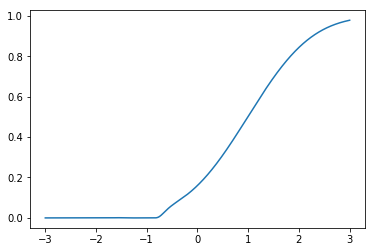

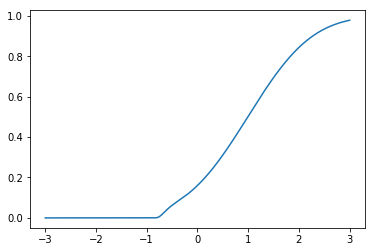

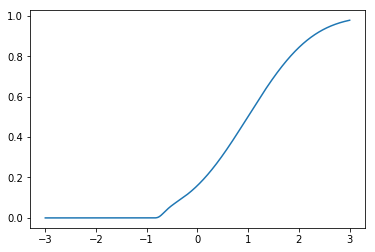

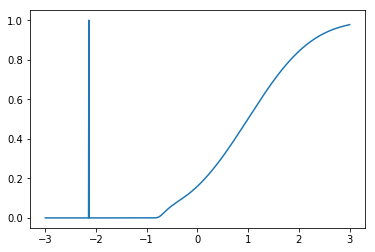

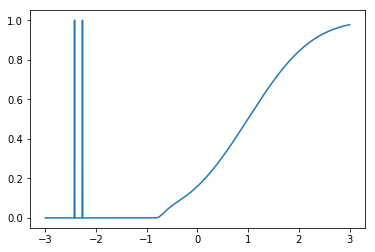

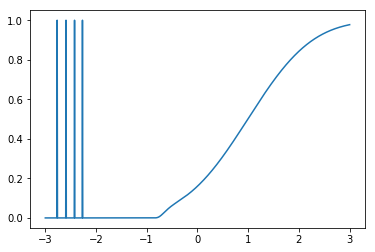

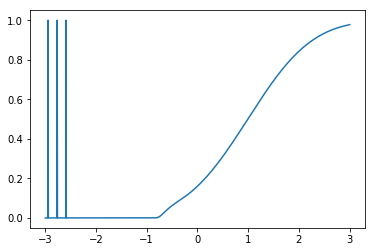

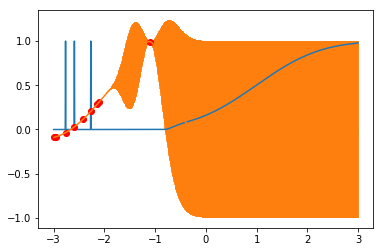

In [16]:
starting_x = [-1.1, -2.1]

BO(starting_x, f2, acq_func = EI, budget = 10)

Max x:  -0.515515515516
Max y:  1.15277238195


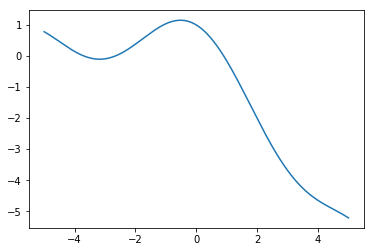

In [17]:
x_pred = np.linspace(-5, 5, 1000)
plt.plot(x_pred, f2(x_pred))
ind = np.argmax(f2(x_pred))
print("Max x: ", x_pred[ind])
print("Max y: ", max(f2(x_pred)))

# Quasi-random sampling + Local Optimization of Acquisition Function

For high dimensional space, using np.argmax is not a scalable solution. 

We start by projecting the observations to the unit hypercube, as defined by bounds of the optimization.
Gaussian process hyperparameters, ✓, are sampled using the slice sampling algorithm
of Murray and Adams [2]. In order to find the maximum of the multimodal acquisition function
a(x ; {xn, yn}, ✓) in a continuous domain, first discrete candidate points are densely sampled in the
unit hypercube using a low discrepancy Sobol sequence [1]. Each of these candidates is then subjected
to a bounded optimization over the integrated acquisition function. Precisely, the minimum of
the acquisition function, averaged over GP hyperparameter samples, is computed with the input initialized
at each of the candidate points. As the acquisition functions in this work can all be expressed
analytically in closed form, standard gradient descent techniques can be used. This yields a new set
of candidate points, each of which is located at a local optimum of the integrated acquisition function.
The next point to be evaluated in the Bayesian optimization procedure is then selected as the
candidate point with the highest integrated acquisition function. Algorithm 1 outlines the procedure
for selecting the next candidate point to evaluate while integrating over hyperparameter samples. In
the event of pending experiments, {xj}J
j=1, fantasized corresponding outcomes, {yj}J
j=1, can be
efficiently sampled from the Gaussian process posterior for each hyperparameter sample and added
to the observation set, before computing the integrated acquisition function.

In [18]:
def max_acqf(acqf, num_realizations = 5):
    # Generate initial sample points
    import sobol_seq
    num_dim = acqf.shape[0]
    linespace = acqf.shape[1]
    sample_ind = sobol_seq.i4_sobol_generate(num_dim, num_realizations) # gives index of samples over range 0 to 1
    sample_ind = np.rint(sample_ind*linespace) # Gives actual list indexes, rounded to integers
    
    
    
    return 0
    
    
    

In [19]:
test = np.array([np.arange(1,1000),np.arange(1,1000)])
test

array([[  1,   2,   3, ..., 997, 998, 999],
       [  1,   2,   3, ..., 997, 998, 999]])

In [20]:
import sobol_seq
num_dim = test.shape[0]
num_realizations = 5
linespace = test.shape[1]
init = sobol_seq.i4_sobol_generate(num_dim, num_realizations)
init = np.rint(init*linespace) 
init

array([[ 500.,  500.],
       [ 749.,  250.],
       [ 250.,  749.],
       [ 375.,  375.],
       [ 874.,  874.]])

In [21]:
from scipy.optimize import minimize

def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead', 
               options = {'xtol': 1e-8, 'disp': True})
print(res.x) # gives minimum point


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571
[ 1.  1.  1.  1.  1.]
